# AdFlush Inference

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline
# h2o.init()
h2o.init(nthreads = 12, max_mem_size = "64g", enable_assertions = False)
h2o.no_progress()

import re2 as re
from category_encoders.target_encoder import TargetEncoder
import xgboost
import shap
# from shap_selection import feature_selection
from sklearn.ensemble import RandomForestClassifier

import onnxmltools
import onnx
import onnxruntime as ort
from keras.layers import Input, Dense, Add
from keras.models import Model
import re2 as re


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [21]:
def metrics(true, pred):
    print(f"Accuracy : {accuracy_score(true, pred)} ")
    print(f"Precision : {precision_score(true, pred)} ")
    print(f"Recall : {recall_score(true, pred)} ")
    print(f"F1 : {f1_score(true, pred)} ")
    # Number of attacks
    total_attacks = len(true)
    
    # Number of successful attacks (misclassifications)
    successful_attacks = sum(true != pred)
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()

    # Calculate FNR
    fnr = fn / (tp + fn)
    print('False Negative Rate:', fnr)

    # Calculate FPR
    fpr = fp / (fp + tn)
    print('False Positive Rate:', fpr)
    # ASR
    asr = successful_attacks / total_attacks
    print(asr)

In [5]:
adflush_df = pd.read_csv('AdFlush_features.csv', index_col=0)

In [6]:
# temp_df = adflush_df.copy()
# URL = ['url_length', 'is_third_party',
#        'keyword_char_present', 'req_url_33', 'req_url_135',
#        'req_url_179', 'fqdn_4', 'fqdn_13', 'fqdn_14', 'fqdn_15', 'fqdn_23',
#        'fqdn_26', 'fqdn_27']
# Header = ['content_policy_type', 'num_get_cookie']
# Javscript = ['brackettodot', 'ng_0_0_2', 'ng_0_15_15', 'ng_2_13_2',
#        'ng_15_0_3', 'ng_15_0_15', 'ng_15_15_15', 'avg_ident',
#        'avg_charperline', 'num_get_storage', 'num_set_storage']

# temp_df = temp_df.drop(Javscript, axis=1)

In [9]:
train, test = train_test_split(adflush_df, test_size=0.2, random_state=42)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

y = 'label'
x = list(train)
x.remove(y)

h2o_train = h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)

h2o_train[y] = h2o_train[y].asfactor()
h2o_test[y] = h2o_test[y].asfactor()


In [11]:
#### FOR AUTOML TRAINING. ####

# aml = H2OAutoML(max_runtime_secs=3600, max_models=None, exclude_algos=['XGBoost', 'StackedEnsemble'], nfolds=5)
# # aml = H2OAutoML()
# aml.train(x = x, y = y, training_frame = h2o_train, leaderboard_frame = h2o_test)

In [12]:
model = onnx.load('AdFlush.onnx')
# Check that the IR is well formed
onnx.checker.check_model(model)
# Create an ONNX runtime session
ort_session = ort.InferenceSession('AdFlush.onnx')
input_data = test.drop('label', axis=1).values.astype('float32')
input_name = ort_session.get_inputs()[0].name

# Run the inference session to get the prediction results
tmp = ort_session.run(None, {input_name: input_data})

In [22]:
# true = np.where(np.array(new_target3) > 0.5, 1, 0)
true = test.label
pred = pd.Series(tmp[0].astype(int), name='pred')
label_name = ort_session.get_outputs()[0].name
pred_onx = ort_session.run([label_name], {input_name: input_data})[0]
metrics(true, pred) # accu prec recl f1-sc
# y_pred_proba = model.predict_proba(pred_onx)[:,1]
roc_auc_score(true, pred_onx.astype('float64'))

Accuracy : 0.9863640743952973 
Precision : 0.9928697928697928 
Recall : 0.9728245288428168 
F1 : 0.9827449545759405 
False Negative Rate: 0.027175471157183165
False Positive Rate: 0.004641185256468088
0.013635925604702708


0.9840916717931744

In [27]:
path = 'AdFlush_mojo.zip'
h2o_model = h2o.import_mojo(path)

pred = h2o_model.predict(h2o_test)
pred = pred.as_data_frame().predict.to_list()
metrics(test['label'], pred) # accu prec recl f1-sc
# y_pred_proba = model.predict_proba(pred_onx)[:,1]
roc_auc_score(test['label'], pred)

Accuracy : 0.9865809000674569 
Precision : 0.9890499244032438 
Recall : 0.9772003681740679 
F1 : 0.9830894407675026 
False Negative Rate: 0.02279963182593213
False Positive Rate: 0.007187321444681683
0.013419099932543125


0.9850065233646931

In [ ]:
##### MOJO zip model to ONNX Converter

# path = 'AdFlush_mojo.zip'
# onnx_model = onnxmltools.convert_h2o(path, target_opset=9)
# input_name = onnx_model.graph.input[0].name
# input_name
# # onnx_model = order_conversion(
# #     onnx_graph=onnx_model,
# #     input_op_names_and_order_dims={f"{input_name}": ['None', 'None']},
# #     non_verbose=True
# # )
# onnxmltools.utils.save_model(onnx_model, 'AdFlush.onnx')


In [35]:
h2o_model

Model Details
=============
H2OGenericEstimator : Import MOJO Model
Model Key: Generic_model_python_1698036446057_1146


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    166                166                         1.26761e+07            0            16           14.3614       1             10179         6075.99

ModelMetricsBinomialGeneric: generic
** Reported on train data. **

MSE: 0.0009417131022634931
RMSE: 0.030687344333837248
LogLoss: 0.008132870023044612
Mean Per-Class Error: 0.0005522472490031412
AUC: 0.9999896539582069
AUCPR: 0.999986665295031
Gini: 0.9999793079164139

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3609434286480285
       0       1       Error    Rate
-----  ------  ------  -------  ----------------
0      398782  230     0.0006   (230.0/399012.0)
1      140     264976  0.0005   (140.0/265116.0)
Total  398922  265206  0.0006   (370.0/664128.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360943     0.999302  226
max f2                       0.288259     0.999526  237
max f0point5                 0.491116     0.999321  206
max accuracy                 0.360943     0.999443  226
max precision                0.99983      1         0
max recall                   0.00404137   1         377
max specificity              0.99983      1         0
max absolute_mcc             0.360943     0.998839  226
max min_per_class_accuracy   0.37152      0.999438  225
max mean_per_class_accuracy  0.324507     0.999459  231
max tns                      0.99983      399012    0
max fns                      0.99983      216616    0
max fps                      0.000185655  399012    399
max tps                      0.00404137   265116    377
max tnr                      0.99983      1         0
max fnr                      0.99983      0.817061  0
max fpr                      0.000185655  1         399
max tpr                      0.00404137   1         377

Gains/Lift Table: Avg response rate: 39.92 %, avg score: 39.92 %
group    cumulative_data_fraction    lower_threshold    lift         cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -----------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100011                   0.999906           2.50505      2.50505            1                0.99993      1                           0.99993             0.0250532       0.0250532                  150.505   150.505            0.0250532
2        0.0200007                   0.999866           2.50505      2.50505            1                0.999884     1                           0.999907            0.0250494       0.0501026                  150.505   150.505            0.0501026
3        0.0300002                   0.999838           2.50505      2.50505            1                0.999851     1                           0.999888            0.0250494       0.075152                   150.505   150.505            0.075152
4        0.0400028                   0.999815           2.50505      2.50505            1                0.999826     1                           0.999873            0.025057        0.100209                   150.505   150.505            0.100209
5        0.0500039                   0.999797           2.50505      2.50505   

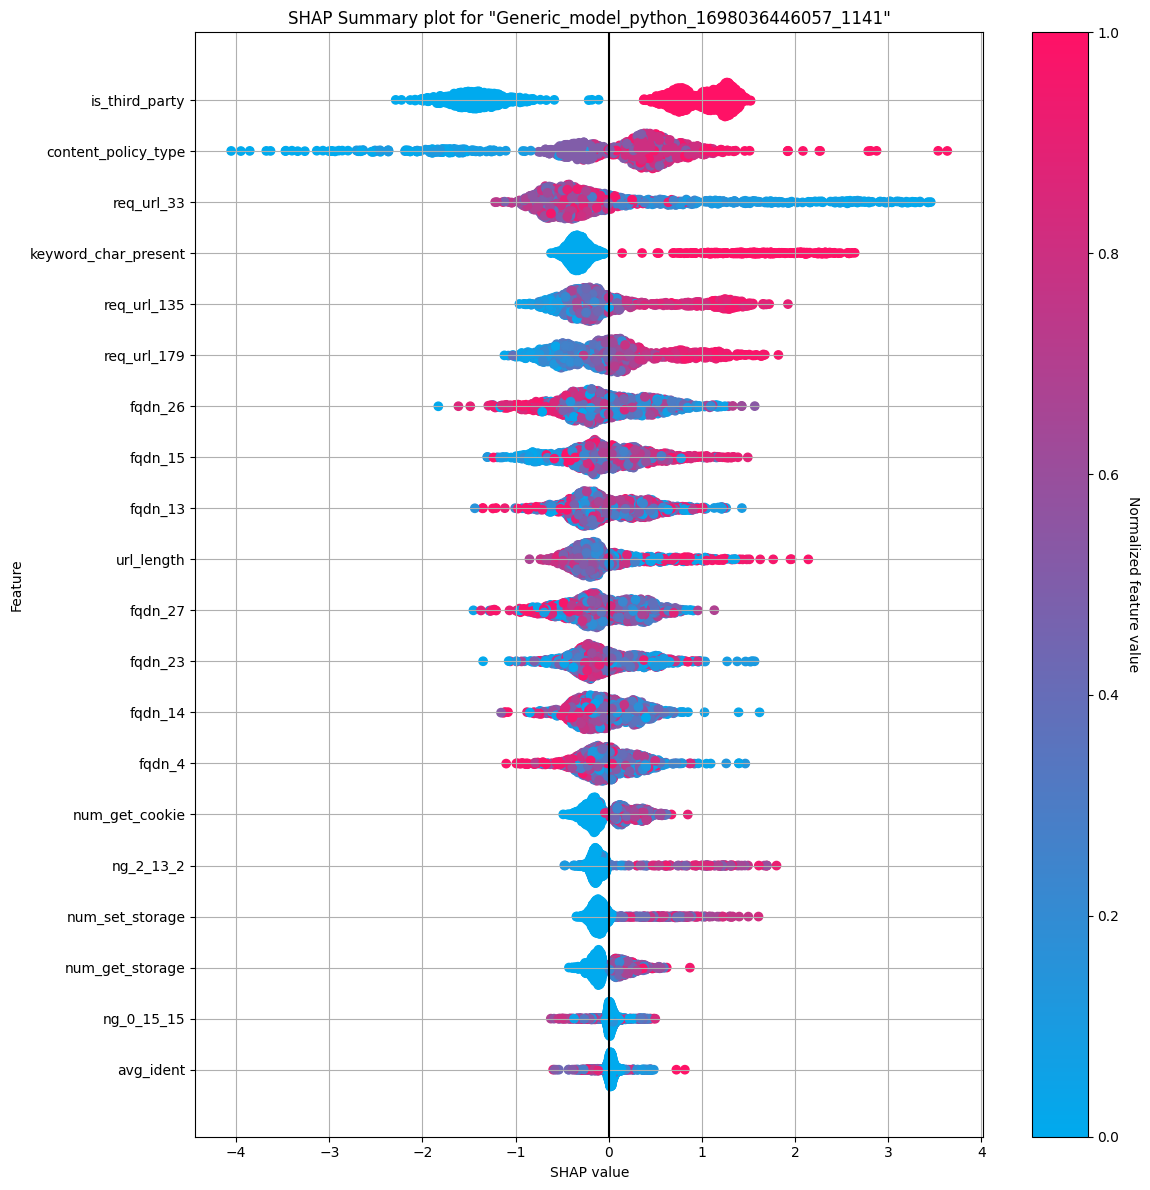

In [19]:
h2o_model.shap_summary_plot(h2o_test)

In [28]:
#  'response_column': 'label',
#  'ignored_columns': [],
#  'ignore_const_cols': True,
#  'offset_column': None,
#  'weights_column': None,
#  'balance_classes': False,
#  'class_sampling_factors': None,
#  'max_after_balance_size': 5.0,
#  'max_confusion_matrix_size': 20,
#  'ntrees': 166,
#  'max_depth': 16,
#  'min_rows': 5.0,
#  'nbins': 20,
#  'nbins_top_level': 1024,
#  'nbins_cats': 1024,
#  'r2_stopping': 1.7976931348623157e+308,
#  'stopping_rounds': 0,
#  'stopping_metric': 'logloss',
#  'stopping_tolerance': 0.0012270834667786677,
#  'max_runtime_secs': 778.0,
#  'seed': 7352808894752235504,
#  'build_tree_one_node': False,
#  'learn_rate': 0.1,
#  'learn_rate_annealing': 1.0,
#  'distribution': 'bernoulli',
#  'quantile_alpha': 0.5,
#  'tweedie_power': 1.5,
#  'huber_alpha': 0.9,
#  'checkpoint': None,
#  'sample_rate': 0.9,
#  'sample_rate_per_class': None,
#  'col_sample_rate': 0.7,
#  'col_sample_rate_change_per_level': 1.0,
#  'col_sample_rate_per_tree': 0.4,
#  'min_split_improvement': 1e-05,
#  'histogram_type': 'UniformAdaptive',
#  'max_abs_leafnode_pred': 1.7976931348623157e+308,
#  'pred_noise_bandwidth': 0.0,
#  'categorical_encoding': 'Enum',
#  'calibrate_model': False,
#  'calibration_frame': None,
#  'calibration_method': 'PlattScaling',
#  'custom_metric_func': None,
#  'custom_distribution_func': None,
#  'export_checkpoints_dir': None,
#  'in_training_checkpoints_dir': None,
#  'in_training_checkpoints_tree_interval': 1,
#  'monotone_constraints': None,
#  'check_constant_response': True,
#  'gainslift_bins': -1,
#  'auc_type': 'AUTO',
#  'interaction_constraints': None,
#  'auto_rebalance': True}